### Connect to Google Drive to access Dataset

In [1]:
'''
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/COVID-19 Detection using CT Scan Images'
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n%cd '/content/drive/My Drive/COVID-19 Detection using CT Scan Images'\n"

In [2]:
%ls

 Volume in drive D is New Volume
 Volume Serial Number is A87E-C2A3

 Directory of d:\project_1_prototype\Medical-Image-Processing\Research

16-09-2022  11:29    <DIR>          .
16-09-2022  11:29    <DIR>          ..
16-09-2022  11:23    <DIR>          .ipynb_checkpoints
15-09-2022  12:36         2,376,455 InceptionV3_Chest.ipynb
16-09-2022  11:29            41,731 InceptionV3_CT.ipynb
15-09-2022  12:36         2,408,999 RESNET Chest.ipynb
15-09-2022  12:36         2,834,886 RESNET_CT.ipynb
15-09-2022  12:36         2,356,677 VGG chest.ipynb
15-09-2022  12:36         2,898,392 VGG_CT.ipynb
15-09-2022  12:36         2,390,333 Xception_chest.ipynb
15-09-2022  12:36         2,980,996 Xception_CT.ipynb
               8 File(s)     18,288,469 bytes
               3 Dir(s)  310,985,691,136 bytes free


### Import all dependencies

In [3]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

### Define Few Parameters

In [6]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = '../Artifacts/raw_data/ct scan/CT_COVID'
noncovid_path = '../Artifacts/raw_data/ct scan/CT_NonCOVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [7]:
# Visualize file variable contents
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("Total Count: ",len(noncovid_files))

First 5 Covid Files:  ['../Artifacts/raw_data/ct scan/CT_COVID\\2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png', '../Artifacts/raw_data/ct scan/CT_COVID\\2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%1.png', '../Artifacts/raw_data/ct scan/CT_COVID\\2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-91.png', '../Artifacts/raw_data/ct scan/CT_COVID\\2020.01.24.919183-p27-132.png', '../Artifacts/raw_data/ct scan/CT_COVID\\2020.01.24.919183-p27-133.png']
Total Count:  349
First 5 NonCovid Files:  ['../Artifacts/raw_data/ct scan/CT_NonCOVID\\0.jpg', '../Artifacts/raw_data/ct scan/CT_NonCOVID\\1%0.jpg', '../Artifacts/raw_data/ct scan/CT_NonCOVID\\1%1.jpg', '../Artifacts/raw_data/ct scan/CT_NonCOVID\\1%2.jpg', '../Artifacts/raw_data/ct scan/CT_NonCOVID\\10%0.jpg']
Total Count:  397


### Fetch Images and Class Labels from Files (This might take a while)

In [8]:
# Fetch Images and Class Labels from Files
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per kera
  image = cv2.resize(image,(224,224)) # resize as per model
  covid_images.append(image) # append image
  covid_labels.append('CT_COVID') # append class label
  
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

### Visualize First 40 Images from Data set

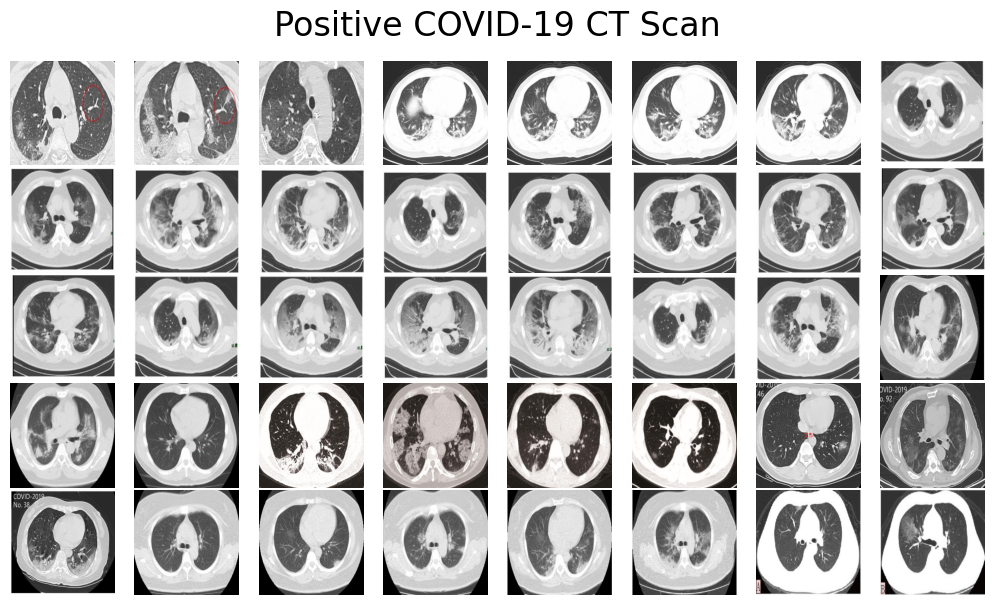

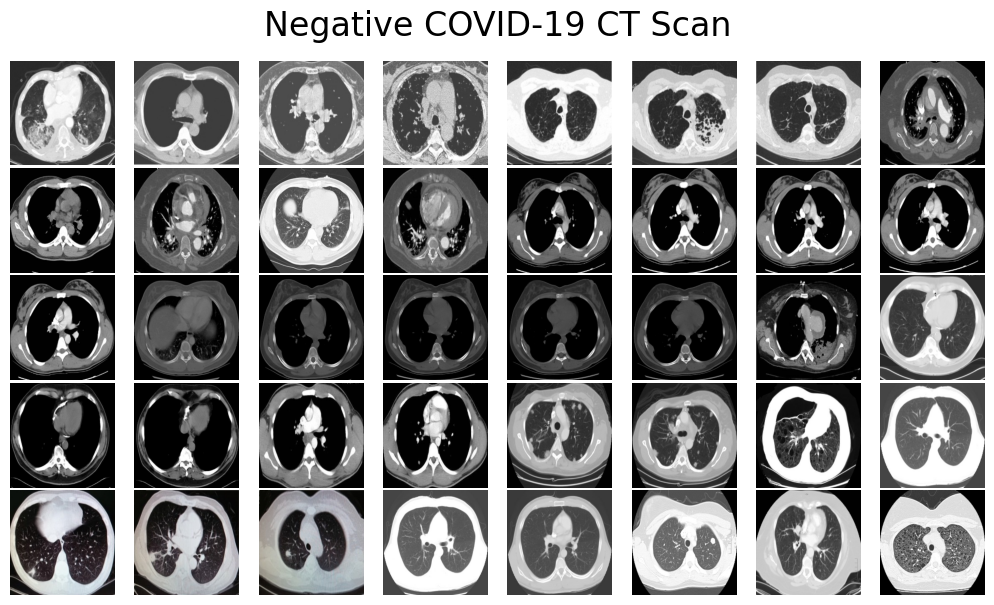

In [9]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 CT Scan')
plot_images(noncovid_images, 'Negative COVID-19 CT Scan')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [10]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

### **Train Test Split**

In [11]:
# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

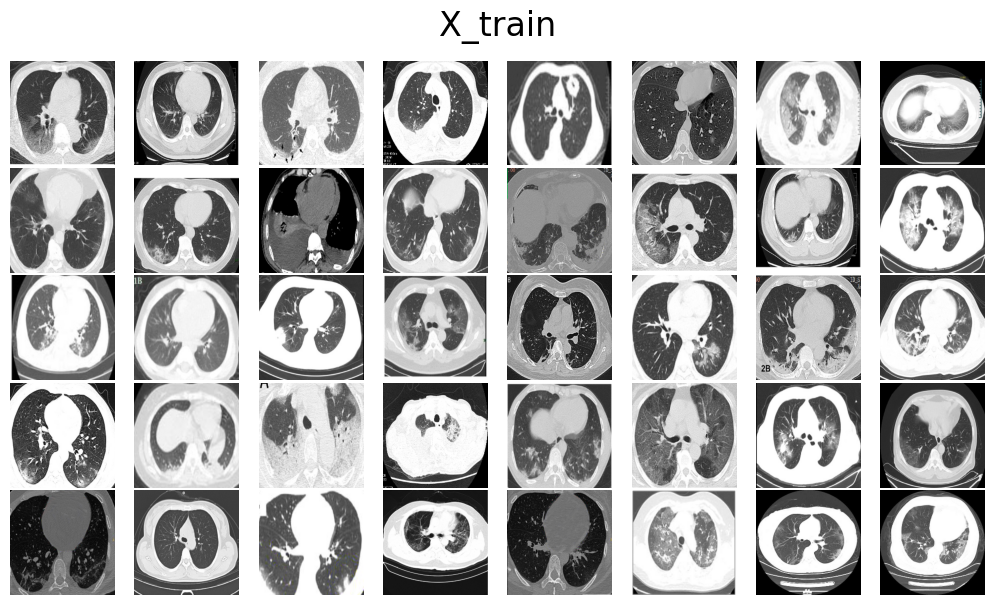

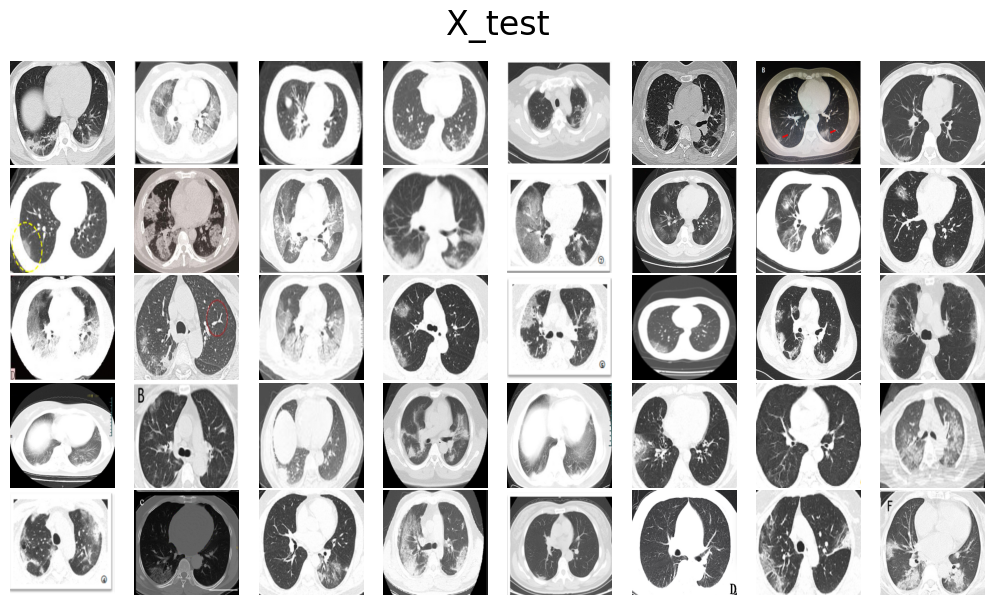

In [12]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

### **Building and Visualizing model**

In [13]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

87916544/87910968 [==============================] - 71s 1us/step


In [14]:
# Visualize Model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### **Image Augmentation**
#### To train on images at different positions, angles, flips, etc

In [15]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

### **Training the model**

In [31]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=250)

Epoch 1/250
18/18 [==============================] - 72s 3s/step - loss: 2.1704 - accuracy: 0.8708 - val_loss: 3.3401 - val_accuracy: 0.7733
Epoch 2/250
18/18 [==============================] - 61s 3s/step - loss: 2.0544 - accuracy: 0.8557 - val_loss: 3.6874 - val_accuracy: 0.8000
Epoch 3/250
18/18 [==============================] - 68s 4s/step - loss: 1.9398 - accuracy: 0.8691 - val_loss: 4.2391 - val_accuracy: 0.7733
Epoch 4/250
18/18 [==============================] - 71s 4s/step - loss: 2.1390 - accuracy: 0.8607 - val_loss: 2.5623 - val_accuracy: 0.8067
Epoch 5/250
18/18 [==============================] - 71s 4s/step - loss: 1.8977 - accuracy: 0.8742 - val_loss: 2.6944 - val_accuracy: 0.8067
Epoch 6/250
18/18 [==============================] - 74s 4s/step - loss: 2.0480 - accuracy: 0.8758 - val_loss: 4.7894 - val_accuracy: 0.7333
Epoch 7/250
18/18 [==============================] - 77s 4s/step - loss: 2.1771 - accuracy: 0.8540 - val_loss: 2.3910 - val_accuracy: 0.8133
Epoch 8/250
1

In [32]:
# Save Model and Weights
model.save('../Artifacts/models/inception_ct.h5')
model.save_weights('../Artifacts/models/inception_weights_ct.hdf5')

In [33]:
# Load saved model
model = load_model('../Artifacts/models/inception_ct.h5')

### **Making Predicions**

In [34]:
y_pred = model.predict(X_test, batch_size=batch_size)

### Visulaizing First 10 predictions

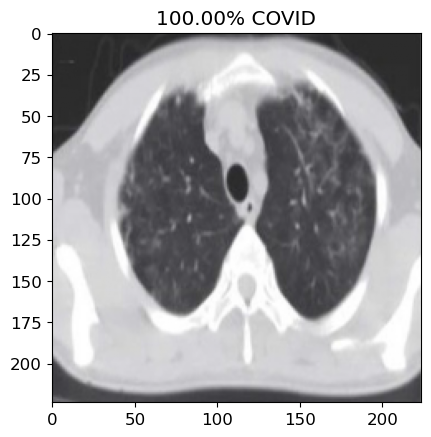

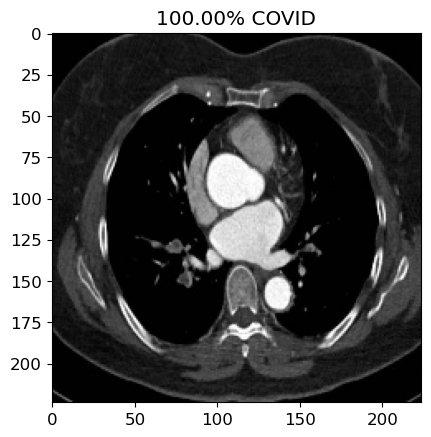

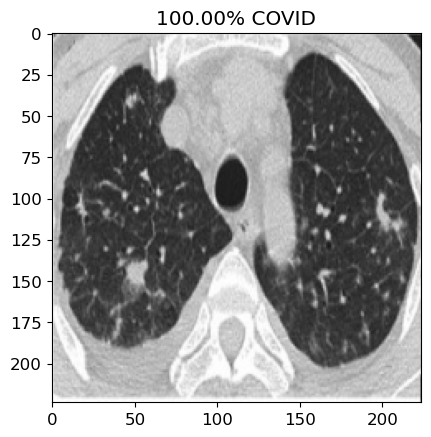

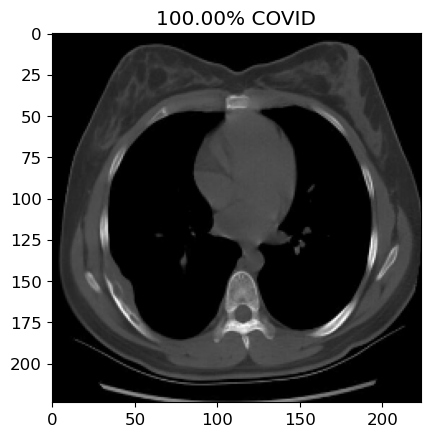

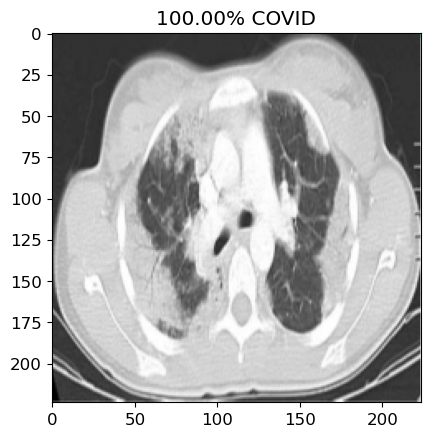

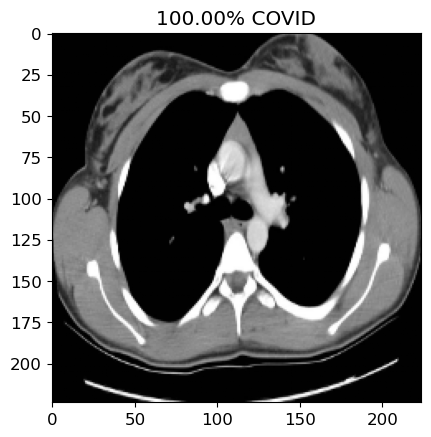

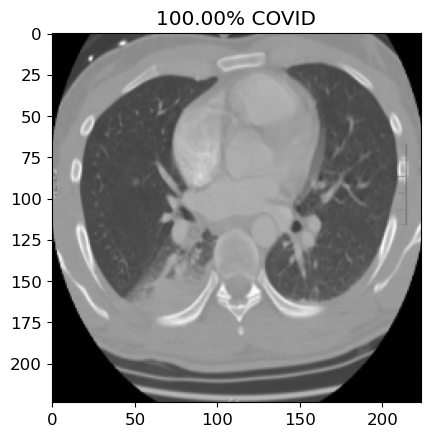

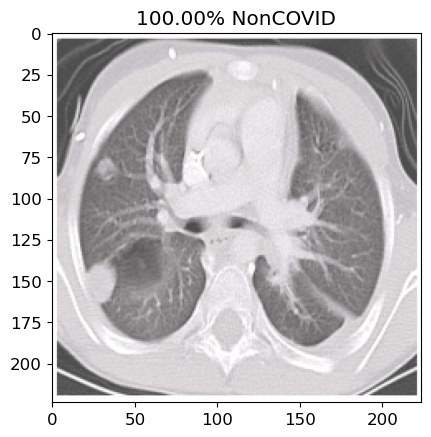

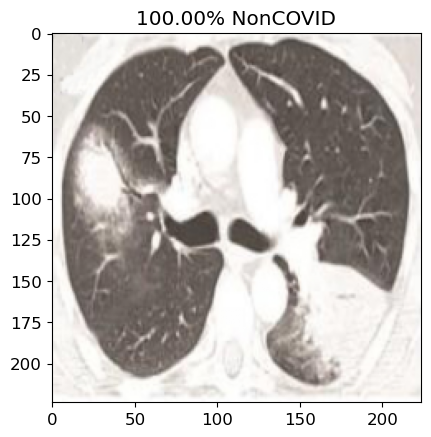

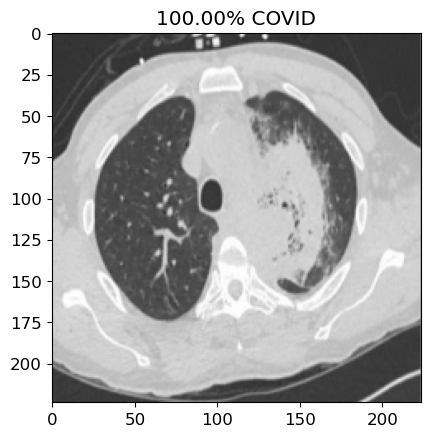

In [35]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.style.reload_library
  plt.imshow(X_test[index])
  plt.show()

In [36]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

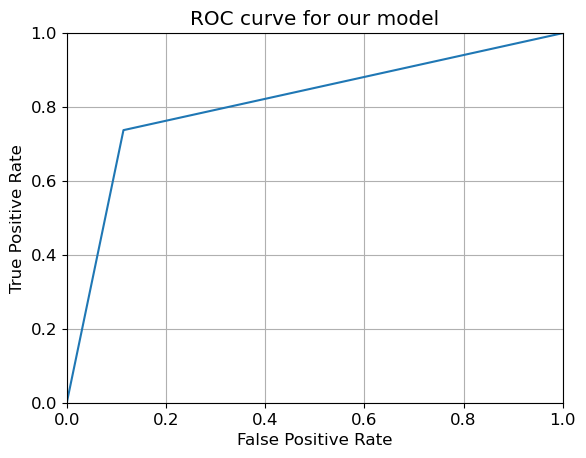

In [37]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


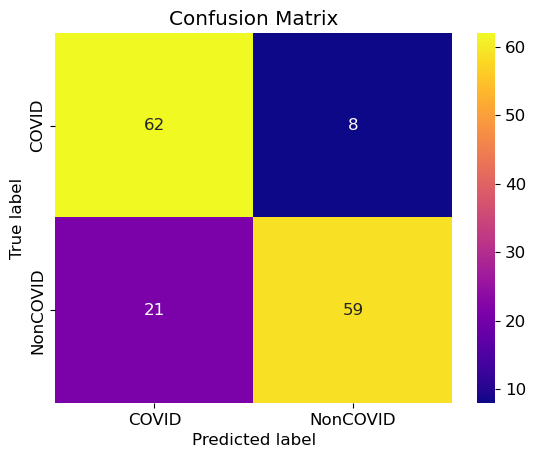

Confusion Matrix with Normalized Values


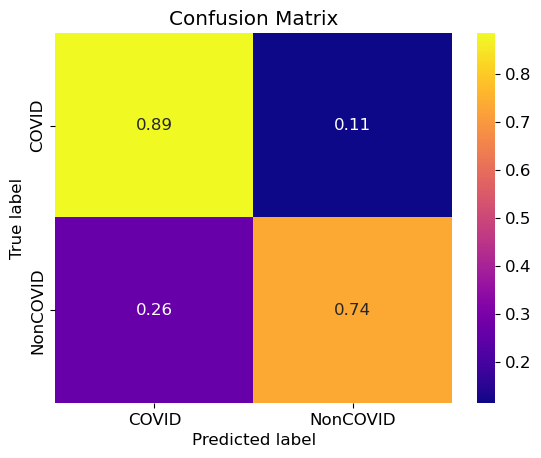

In [38]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.75      0.89      0.81        70
           1       0.88      0.74      0.80        80

    accuracy                           0.81       150
   macro avg       0.81      0.81      0.81       150
weighted avg       0.82      0.81      0.81       150



### **Accuracy and Loss Plots**

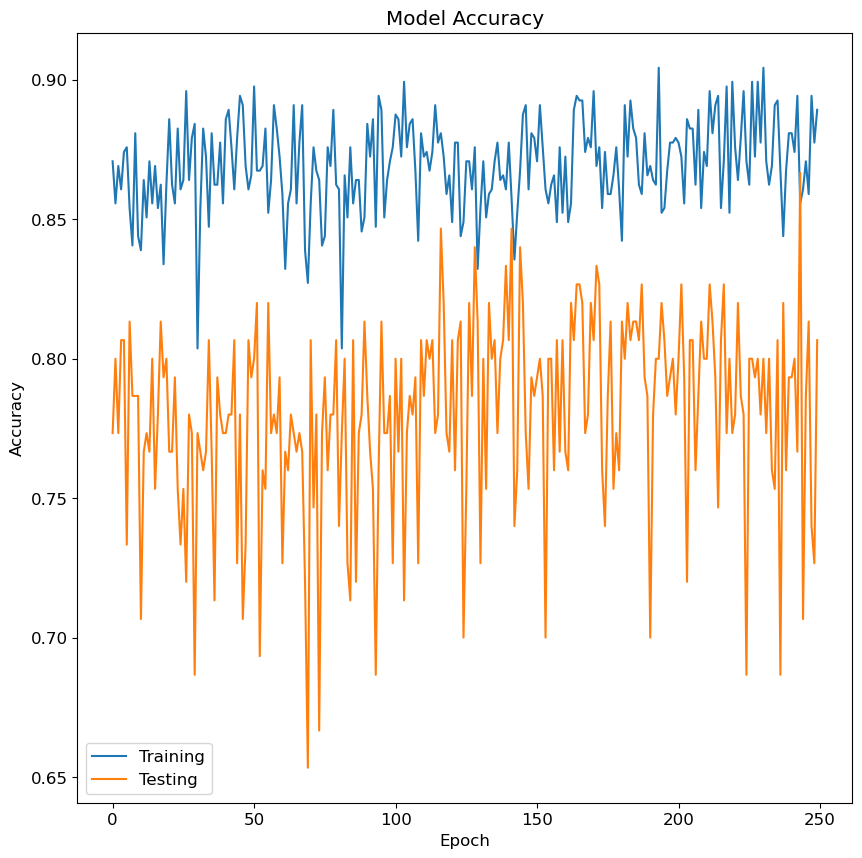

In [40]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_ct_accuracy.png')
plt.show()


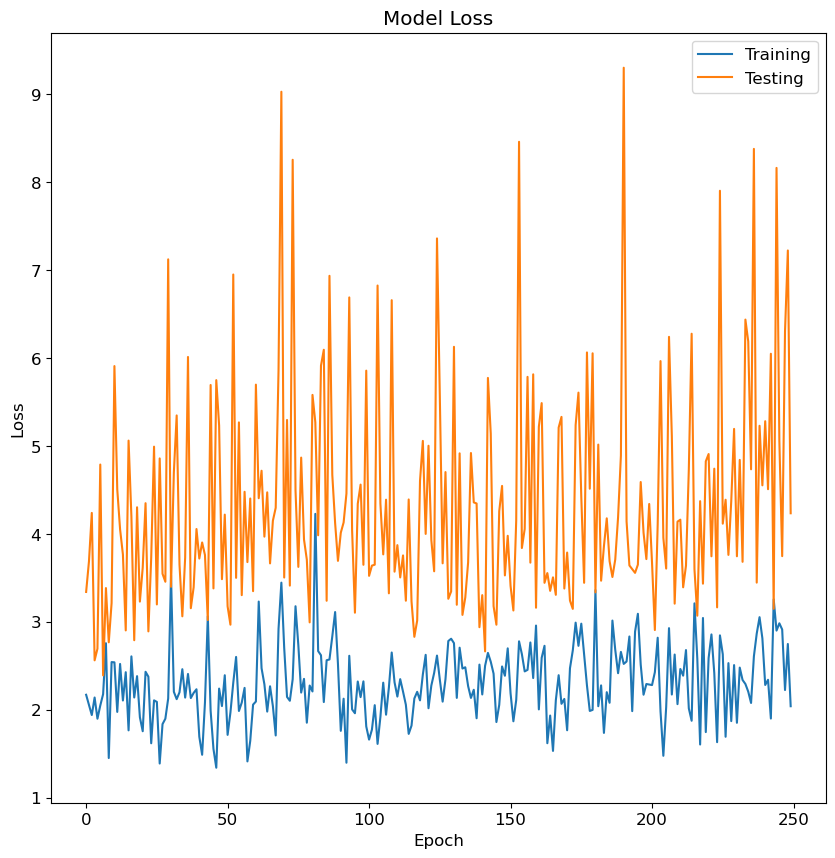

In [41]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_ct_loss.png')
plt.show()

In [42]:
!pip show flask

Name: Flask


Version: 2.2.2
Summary: A simple framework for building complex web applications.
Home-page: https://palletsprojects.com/p/flask
Author: Armin Ronacher
Author-email: armin.ronacher@active-4.com
License: BSD-3-Clause
Location: d:\project_1_prototype\medical-image-processing\env\lib\site-packages
Requires: click, importlib-metadata, itsdangerous, Jinja2, Werkzeug
Required-by: 
